<h1 style="text-align: center;">Module 1. Structured data processing using neural networks
</h1>
<h2 style="text-align: center;">Topic 2. Logistic regression. Artificial neuron</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
# filter warnings
warnings.filterwarnings('ignore')

# from google.colab import drive
# drive.mount('/content/drive')

## Dataset owerview

[Spaceship Titanic dataset](https://www.kaggle.com/competitions/spaceship-titanic/overview)

**Data Field Description:**
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Exploratory Data Analysis

In [2]:
# Reading data
# url = '/content/drive/MyDrive/ds/spaceship-titanic/train.csv'
url = 'https://raw.githubusercontent.com/alexvekh/DL-course/main/data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv'
df = pd.read_csv(url)

df = df.set_index('PassengerId')

In [3]:
 # Dataset preview
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Number of records and columns
df.shape

(8693, 13)

In [5]:
# Basic dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [6]:
TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]
FEATURES

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name']

In [7]:
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]


In [8]:
cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [9]:
cont_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [10]:
print(f'Number of categorical features: {len(cat_features)}')
print('Categorical features:', cat_features, '\n')
print(f'Number of continuos features: {len(cont_features)}')
print('Continuos features:', cont_features, '\n')
print(f'Number of text features: {len(text_features)}')
print('Text features:', text_features)

Number of categorical features: 4
Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'] 

Number of continuos features: 6
Continuos features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 

Number of text features: 2
Text features: ['Cabin', 'Name']


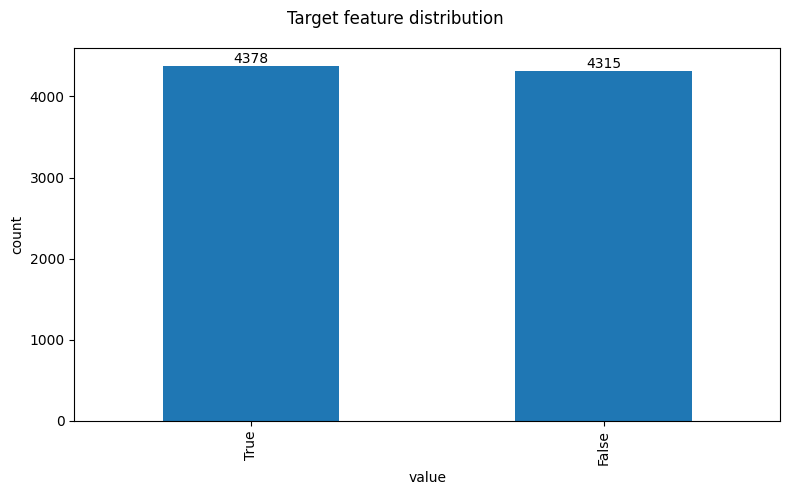

In [11]:
ax = df[TARGET].value_counts().plot(kind='bar', figsize=(8, 5))
for i in ax.containers:
    ax.bar_label(i)
    ax.set_xlabel("value")
    ax.set_ylabel("count")

plt.suptitle("Target feature distribution")

plt.tight_layout()
plt.show()

We can see that the target feature is distributed equally. That means we can use accuracy as a metric.

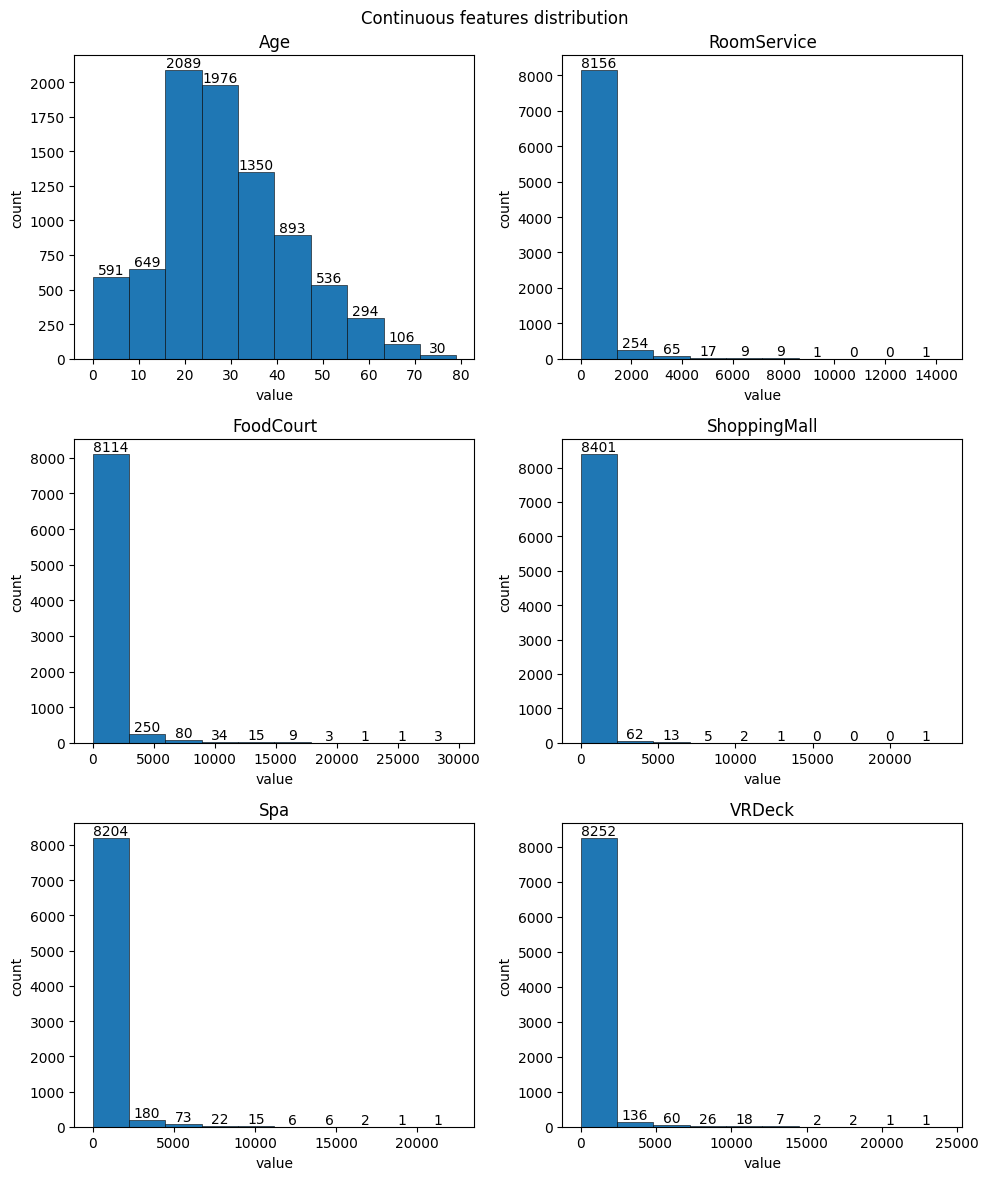

In [12]:
# Continuous features
ax = df.loc[:, cont_features].hist(figsize=(10, 12), grid=False, edgecolor='black', linewidth=.4)
for row in ax:
    for col in row:
        for i in col.containers:
            col.bar_label(i)
            col.set_xlabel("value")
            col.set_ylabel("count")

plt.suptitle("Continuous features distribution")

plt.tight_layout()
plt.show()

It looks like most of the passengers didn't use luxury services - all luxury amenities plots are heavily left-skewed.

Let's create binary features for this services: if passanger used the service or not.

In [13]:
services_features = cont_features[1:]

In [14]:
for feature in services_features:
    df[f'used_{feature}'] = df.loc[:, feature].apply(lambda x: 1 if x > 0 else 0)

In [15]:
# Correlation matrix

df.loc[:, cont_features + ['CryoSleep', 'VIP', TARGET]].corr().style.background_gradient()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.074273,0.092819,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.252396,0.058785,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,-0.211510,0.129799,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,-0.212514,0.018295,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.203991,0.061059,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.198857,0.125974,-0.207075
CryoSleep,-0.074273,-0.252396,-0.211510,-0.212514,-0.203991,-0.198857,1.000000,-0.081402,0.468645
VIP,0.092819,0.058785,0.129799,0.018295,0.061059,0.125974,-0.081402,1.000000,-0.037650
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,0.468645,-0.037650,1.000000


We can see that input features are not correlated with oneself. So we won't drop any of the features.

Pay attention: Target leakage


## Preprocessing

In [16]:
# Підготовка й обробка даних (feature engineering)
# Проведемо заміну пропущених значень. Для кожної змінної заповнимо пропущені значення медіаною значень цієї змінної.
# Imputing Missing Values

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

In [17]:
df['HomePlanet'] = df['HomePlanet'].map(str)

In [18]:
# Оскільки змінні HomePlanet і Destination є категоріальними,
# замінимо пропущені значення на фіктивне значення (dummy value).
df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

In [19]:
# Змінні CryoSleep і VIP також містять пропущені значення.
# Це бінарні змінні.  Тож подивимось, якого типу результат переважає
# — True чи False, і використаємо ці значення, щоб заповнити пропуски.

# Але перед цим, щоб не втратити інформацію про пропущені дані,
# створимо дві додаткові бінарні змінні
# — CryoSleep_is_missing і VIP_is_missing.
# Значення 1 - даний рядок відповідної колонки мав пропущене значення,
# а 0 — не мав.
df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

In [20]:
# Виведемо розподіл значень True і False за змінними:
display(df['CryoSleep'].value_counts())
display(df['VIP'].value_counts())

,count
CryoSleep,
False,5439
True,3037


,count
VIP,
False,8291
True,199


In [21]:
#Заповнюємо пропуски найбільш присутнім значенням.
df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

Pay attention: we can transform binary/boolean features to categorical if have one or more types of NaNs.

In [22]:
# Для кодування змінних HomePlanet і Destination використаємо метод One-hot encoding.
# Це створює розріджене матричне (sparse matrix) представлення категоріальних даних.

# переваги цього методу:
 #- Дозволяє використовувати категоріальні змінні де треба числові.
 #- Зберігає незалежність змінних і запобігає створенню штучного впорядкування.
    # Тобто, коли кодуємо OrdinalEncoder, кожне унікальне заміняється на порядковий номер від 1 до n
    # Це має сенс, коли є необхідність зберегти властивий порядок або ранжирування категорій.
    # Однак у нашому випадку всі планети є рівноважливими.
# Основний недолік - збільшення розмірності, бо створюється багато стовпів.
   # Це може призвести до збільшення складності моделі й перенавчання (overfitting).

# Оскільки нам потрібно закодувати тільки 2 змінні, кожна з яких містить тільки 4 категорії,
# ми не створимо завелику кількість ознак. Отже, метод One-hot encoding є виправданим.

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

In [23]:
dummies

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_Skaro,Destination_TRAPPIST-1e
PassengerId,,,,,,,,
0001_01,0,1,0,0,0,0,0,1
0002_01,1,0,0,0,0,0,0,1
0003_01,0,1,0,0,0,0,0,1
0003_02,0,1,0,0,0,0,0,1
0004_01,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9276_01,0,1,0,0,1,0,0,0
9278_01,1,0,0,0,0,1,0,0
9279_01,1,0,0,0,0,0,0,1


In [24]:
# Додамо отримані змінні до оригінального набору даних і видалимо колонки HomePlanet і Destination.
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

In [25]:
# Оскільки модель, яку ми будемо створювати, очікує на числові значення, перетворюємо цільову ознаку з бінарної на цілочисельну.
df[TARGET] = df[TARGET].astype(int)

In [26]:
bool('true'), bool('False')  # TODO we need to write custom logic

(True, True)

In [27]:
# For now, dropping textual features
# Оскільки наразі ми не обробляємо текстові змінні, видалимо їх.
df.drop(["Name", "Cabin"] , axis=1 ,inplace = True)

In [28]:
# Train/test split

X = df.drop(TARGET , axis =1 )
y = df[TARGET]

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)
# use stratify=y to ensure that the distribution of the target variable will be preserved in train/test datasets
# stratify = y. Цей аргумент забезпечує збереження розподілу цільової змінної в наборах даних train/tets.


In [29]:
# For further computation purpuses, let's transpose input data
# Для подальших коректних обрахунків транспонуємо матрицю вхідних ознак і вектор цільової змінної.
x_train = X_train.T
x_test = X_test.T
y_train = np.expand_dims(y_train.T, 0)
y_test = np.expand_dims(y_test.T, 0)

print('X train size', x_train.shape)
print('X test size', x_test.shape)
print('y train size', y_train.shape)
print('y test size', y_test.shape)

X train size (23, 5824)
X test size (23, 2869)
y train size (1, 5824)
y test size (1, 2869)


## Initializing parameters

In [30]:
# Нам потрібно задати початкові параметри ваг w, які будуть змінюватись під час навчання.
# Є різні способи задання ваг. Один з них — ініціалізувати всі ваги рівними одному числу.
# Нехай усі значення ваг w будуть дорівнювати 0.01 у нашому прикладі,
# а значення зміщення b буде дорівнювати нулю.

# A function to initialize parameters

def initialize_weights_and_bias(dimension):
    # dimension - number of input features
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

## Forward Propagation

In [31]:
# Для логістичної регресії ми виконуємо такі кроки:

# Розраховуємо значення рівняння z = w.T*X + b.
# У цьому рівнянні нам відомі значення всіх змінних:
# X — матриця вхідних ознак, w — вектор ваг, який ми наразі ініціюємо константним значенням 0.01,
# b — зміщення, яке ми прирівняли до 0.
# Поміщаємо значення z у сигмоїду:
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

In [32]:
# Сигмоїда повертає значення ймовірностей, яке ми позначимо як y^
 # (y head y pred).
# Обчислюємо значення функції втрат між реальними значеннями цільової
# змінної (y true) і передбаченими (y pred).
# Функцією втрат, яка добре репрезентує задачу бінарної класифікації,
# є бінарна крос-ентропія (binary cross-entropy loss, BCE).
# Вона має ряд причин для використання:
#    - Імовірнісна інтерпретація: втрата binary cross-entropy loss виводиться з розподілу ймовірностей Бернуллі,
#       який моделює ймовірність бінарного результату. Це дозволяє моделі виводити оцінки ймовірності для кожного класу.
#    - Ефективність обчислень: порівняно з категоріальною крос-ентропією (categorical cross-entropy loss), бінарна крос-ентропія є
#       обчислювально простішою та ефективнішою, оскільки для неї потрібен лише один вихідний нейрон у нейронній мережі.
#    - Обробка незбалансованих даних: коли ви маєте справу з незбалансованими двійковими наборами даних, де один клас є значно поширенішим,
#       ніж інший, бінарну крос-ентропію можна поєднати з такими методами, як зважування класів, щоб покращити продуктивність моделі.
#    - Еквівалентність логістичній регресії: BCE математично еквівалентна максимізації ймовірності моделі логістичної регресії,
#       яка є широко використовуваним методом для бінарних задач.

# Математично вона визначається як −(1−y)⋅log(1−y^)−y⋅log(y^).
# Значення функції втрат розраховується окремо для кожної пари y_true і
#  y_pred​, кожного вхідного значення, а потім сумується для всього набору даних.
# Можемо записати кроки прямого розповсюдження так.
  # 1. Розраховуємо значення функції z. z = np.dot(w.T,x_train) + b
  # 2. Отримуємо вектор значень передбачених значень y_pred після використання сигмоїди. y_head = sigmoid(z)
  # 3. Рахуємо значення функції втрат за формулою. loss = -1*y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head).
  # Отримуємо вектор значень функції втрат для кожного значення цільової змінної y.
  # 4. Підсумовуємо значення функції втрат. Нормуємо результат шляхом ділення на кількість вхідних точок,
  # роблячи його незалежним від розміру набору даних. cost = (np.sum(loss))/x_train.shape[1]
# Отримане число є значенням функції втрат, яке ми мінімізуємо для розв’язання задачі.
# У підсумку отримуємо таку функцію.

def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z) # probabilistic 0-1
    loss = -1*y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    return cost

## Gradient Descent
Зворотне розповсюдження помилки


In [33]:
# In backward propagation we will use y_head that found in forward progation
# Therefore instead of writing backward propagation method, lets combine forward propagation and backward propagation

# Оновлення ваг моделі шляхом розрахунку градієнта є кроком зворотного розповсюдження помилки.

# Тепер ми маємо всі компоненти, аби записати forward and backward pass кодом.
# Ця функція буде повертати значення функції витрат cost і змінну gradients,
# що буде містити значення похідних.


def forward_backward_propagation(w,b,x_train,y_train, eps=1e-5):

    # forward propagation

    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -1*y_train*np.log(y_head+eps)-(1-y_train)*np.log(1-y_head+eps)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling

    # backward propagation

    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}

    return cost,gradients

In [34]:
# ця задача не потребує розбиття даних на мінібатчі.
# (кожної епохи модель буде обробляти тільки один батч розмірністю [кількість вхідних ознак, кількість прикладів].
# Але надалі треба будуть обробки даних батчами.

# Updating(learning) parameters (Напишемо код оновлення ваг моделі. Для кожної епохи будемо виконувати такі кроки:)

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    index = []

    # updating(learning) parameters is number_of_iterarion times

    for i in range(number_of_iterarion):

        # make forward and backward propagation and find cost and gradients
        # 1. Пряме і зворотне розповсюдження. Це дасть нам значення функції втрат і градієнтів.


        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        # 2. Збереження значення функції втрат для того, щоб пізніше намалювати графік зміни функції.
        # Проаналізувавши такий графік, можна оцінити якість навчання моделі (overfitting, underfitting) та вносити корективи до її тренування.
        # Наприклад, змінювати швидкість навчання (learning rate).
        cost_list.append(cost)

        # lets update
        # 3. Оновлення значення ваг моделі.
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        index.append(i)

    # we update(learn) parameters weights and bias

    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list)
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()

    return parameters, gradients, cost_list

In [35]:
# Окремо запишемо код для передбачення значень цільової змінної.
#   1. Отримаємо значення сигмоїди при заданих X, W і b.
#       z = sigmoid(np.dot(w.T,x_test)+b)
#   2. Створимо масив нулів розмірності [1, кількість прикладів].
#       Y_prediction = np.zeros((1,x_test.shape[1]))
# 3. Для кожного значення z, якщо z > 0.5, записуємо значення 1 в Y_prediction, інакше — 0.

def predict(w,b,x_test):

    # x_test is a input for forward propagation

    z = sigmoid(np.dot(w.T,x_test)+b)

    Y_prediction = np.zeros((1,x_test.shape[1]))

    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0)

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Lets put them all together

In [36]:
# Створимо фінальну модель. До неї увійдуть такі кроки:
#   1. Ініціалізація ваг моделі w константними значеннями.
#       w,b = initialize_weights_and_bias(dimension)
#   2. Виконання прямого та зворотного розповсюдження
#       num_iterations разів. parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
#   3. Передбачення значення цільової змінної для тренувального й тестового наборів даних.
#       y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
#       y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
#   4. Розрахунок точності (accuracy) моделі на тренувальних і тестових даних.

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    # initialize

    dimension =  x_train.shape[0]  # that is 4096
    w,b = initialize_weights_and_bias(dimension)

    # do not change learning rate
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)

    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

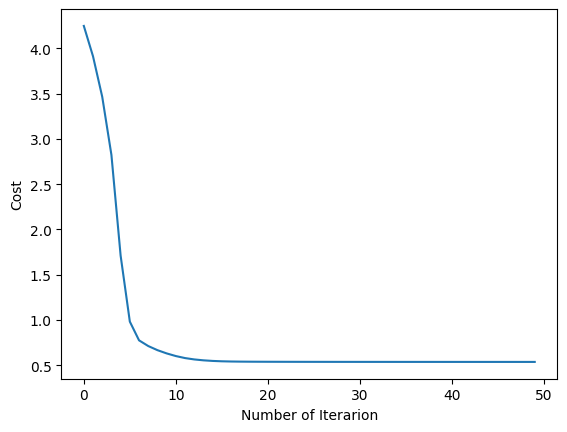

train accuracy: 77.93612637362638 %
test accuracy: 79.36563262460788 %


In [37]:
# Протестуйте різні значення гіперпараметра швидкості навчання. Почніть зі значення 1 і поступово зменшуйте його до 0.00001. Як змінюється графік функції втрат?
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.00001, num_iterations = 50)